# Rede Neural Recorrente usando MultPrevisores

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [18]:
# Carregando a base de dados 
base = pd.read_csv("petr4_treinamento.csv")

In [19]:
# Removendo registros com valores faltantes
base = base.dropna()
base.shape

(1242, 7)

In [20]:
# criando a base de dados para treinamento multprevisores
base_train = base.iloc[:, 1:7].values


## Normalizando os valores da base de treino

In [47]:
# Instanciando um objeto do modulo sklearn usado para normalização de dados numéricos
normalizador = MinMaxScaler(feature_range=(0, 1))

# normalizador para as previsões
normalizador_previsoes = MinMaxScaler(feature_range=(0, 1))
normalizador_previsoes.fit_transform(base_train[:, 0:1])

# Aplicando a normalização dos dados
base_train_norm = normalizador.fit_transform(base_train)
base_train_norm

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

## Colocando os previsores em um formato que uma rede neural recorrente possa ser aplicada

In [28]:
# Listas
previsores = []
preco_real = []

for i in range(90, 1242):
    previsores.append(base_train_norm[i-90: i, 0:6])
    preco_real.append(base_train_norm[i, 0])

# Transformando as listas em array do numpy
previsores, preco_real = np.array(previsores), np.array(preco_real)


## Criando o modelo de rede neural recorrente com keras 

In [29]:
# Instanciando um objeto Squential, utilizado como estrutura para construir o modelo de rede neural recorrente
regressor = Sequential()

# Criando a primeira camada LSTM 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = "sigmoid"))

# Compilando o modelo
regressor.compile(optimizer = "rmsprop",
                  loss = "mean_squared_error",
                 metrics = ["mean_absolute_error"])


### Treinando o modelo

In [31]:
# Configurando os hiperparâmetros do modelo
es = EarlyStopping(monitor="loss", min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath="pesos.h5", monitor="loss", save_best_only=True, verbose = 1)

# Treinando o modelo
regressor.fit(previsores,
              preco_real,
              epochs=100,
              batch_size = 32,
              callbacks=[es, rlr, mcp])


Epoch 1/100
36/36 [==============================] - 30s 505ms/step - loss: 0.0292 - mean_absolute_error: 0.1340

Epoch 00001: loss improved from inf to 0.01926, saving model to pesos.h5
Epoch 2/100
36/36 [==============================] - 18s 502ms/step - loss: 0.0074 - mean_absolute_error: 0.0680

Epoch 00002: loss improved from 0.01926 to 0.00730, saving model to pesos.h5
Epoch 3/100
36/36 [==============================] - 17s 486ms/step - loss: 0.0061 - mean_absolute_error: 0.0619

Epoch 00003: loss improved from 0.00730 to 0.00602, saving model to pesos.h5
Epoch 4/100
36/36 [==============================] - 17s 460ms/step - loss: 0.0050 - mean_absolute_error: 0.0543

Epoch 00004: loss improved from 0.00602 to 0.00498, saving model to pesos.h5
Epoch 5/100
36/36 [==============================] - 11s 290ms/step - loss: 0.0047 - mean_absolute_error: 0.0554

Epoch 00005: loss improved from 0.00498 to 0.00471, saving model to pesos.h5
Epoch 6/100
36/36 [==============================

36/36 [==============================] - 20s 558ms/step - loss: 0.0012 - mean_absolute_error: 0.0258

Epoch 00045: loss did not improve from 0.00102
Epoch 46/100
36/36 [==============================] - 22s 611ms/step - loss: 0.0012 - mean_absolute_error: 0.0242

Epoch 00046: loss did not improve from 0.00102
Epoch 47/100
36/36 [==============================] - 20s 563ms/step - loss: 0.0011 - mean_absolute_error: 0.0241

Epoch 00047: loss improved from 0.00102 to 0.00102, saving model to pesos.h5
Epoch 48/100
36/36 [==============================] - 16s 447ms/step - loss: 0.0011 - mean_absolute_error: 0.0237

Epoch 00048: loss did not improve from 0.00102
Epoch 49/100
36/36 [==============================] - 15s 425ms/step - loss: 0.0011 - mean_absolute_error: 0.0248

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00049: loss improved from 0.00102 to 0.00099, saving model to pesos.h5
Epoch 50/100
36/36 [==============================] - 16s 449

# Carregando base de dados de teste

In [33]:
base_test = pd.read_csv("petr4_teste.csv")
base_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [38]:
# Pegando os valores de da coluna Open
preco_real_test = base_test.iloc[:, 1:2].values

# Concatenando os dados de teste com os dados de treino
frames = [base, base_test]
base_completa = pd.concat(frames)

In [40]:
# Removendo a coluna date
base_completa = base_completa.drop("Date", axis = 1)

In [49]:
# colocando os dados no formato  correto para a rede neural recorrente
entradas = base_completa[len(base_completa) - len(base_test) - 90: ].values

# Normalizando as entradas
entradas = normalizador.transform(entradas)

x_test = []
for i in range(90, 112):
    x_test.append(entradas[i-90:i, 0:6])

# Convertendo para um objeto numpy array
x_test = np.array(x_test)

In [50]:
x_test.shape

(22, 90, 6)

# Fazendo as previsões usando o modelo treinado 

In [52]:
# obtendo as previsões
previsoes = regressor.predict(x_test)

# desfazendo a normalização aplicada as dados anteriormente, apra obter os valores reais 
previsoes = normalizador_previsoes.inverse_transform(previsoes)

## Visoalizando os resultados

In [53]:
previsoes.mean()

17.693117

In [54]:
preco_real_test.mean()

17.87454563636364

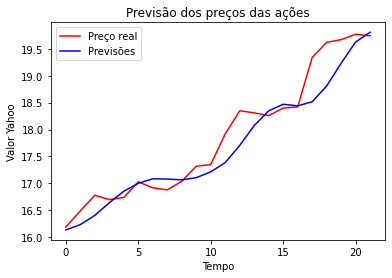

In [55]:
# plotando os gráficos das previsões e do valor real
plt.plot(preco_real_test, color="red", label= "Preço real")
plt.plot(previsoes, color="blue", label="Previsões")
plt.title("Previsão dos preços das ações")
plt.xlabel("Tempo")
plt.ylabel("Valor Yahoo")
plt.legend()
plt.show()